# Tutorial Overview

In questo tutorial vedremo come funzionano gli **autoencoder**. L'autoencoder è un tipo speciale di rete neurale che è allenato per copiare l'input nel suo output. Per esempio, data un'immagine che rappresenta una cifra scritta a mano, l'autoencoder:
1. Fa l'**encoding** dell'immagine in uno spazio di ordine inferiore, definito **spazio latente**;
2. Fa il **decoding** del vettore dello spazio latente per riportarlo all'immagine iniziale.

Graficamente può essere rappresentato così:
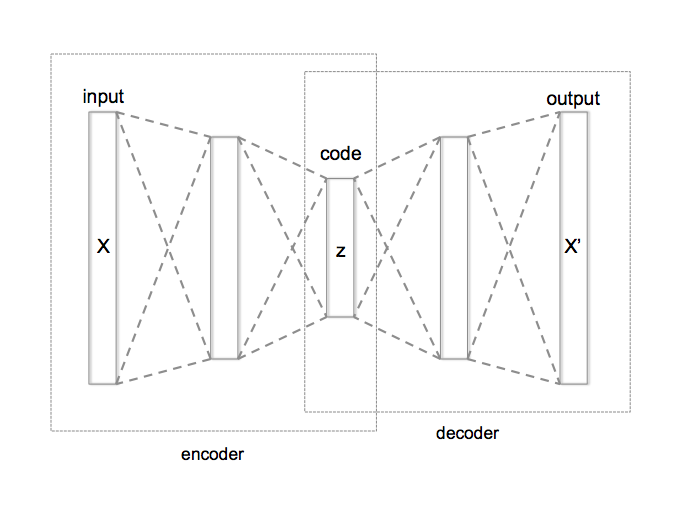

## Caso d'uso

Vedremo un particolare tipo di autoencoder, definito **denoising autoencoder**, applicato al dataset FashionMNIST. In questo dataset sono presenti immagini (28x28) in grayscale rappresentanti dei vestiti.

**L'obiettivo** sarà quello di allenare l'autoencoder a fare denoising di immagini a cui è stato aggiunto del rumore.

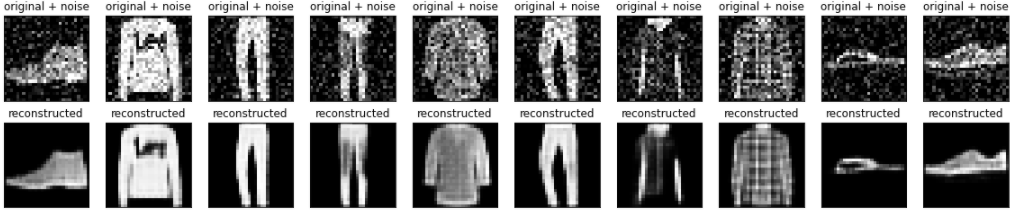

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Carichiamo il dataset

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

Aggiungiamo rumore casuale alle immagini:

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Vediamo un po' cosa ne risulta:

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Creiamo il denoising autoencoder usando l'interfaccia `keras.Model`:

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

Compiliamo il modello con ottimizzatore `adam` e modello `MSE`:

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Alleniamo il modello:

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Vediamo il sommario dell'encoder e del decoder:

In [ ]:
autoencoder.encoder.summary()

In [ ]:
autoencoder.decoder.summary()

E, infine, vediamo come si è comportato nel denoising:

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()